In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import interpolate
import time
import torch
import torch.nn.functional as F
from torch.optim import LBFGS

interp_mode = "bilinear"
align_corners = True


#n_grids = [12,16,20,24,28,32,36,40]
#n_grids = [12,16]
#n_grids = [6,10,14,20,30,40,50]
#n_grids = [6,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,600,700,800,900,1000]
#n_grids = [10,20,30,40,50,60,70,80,90,100]
n_grids = [6,8,12,16,20,24,28,32,36,40,44,48]
#n_grids = [20]
#n_grids = [200]
theta_start = 0
theta_end = np.pi/2
r_start = 3
r_end = 4

a = 0.0
M = 1

errors = []
times = []
ii = 0


for n_grid in n_grids:
    print(n_grid)

    thetas = torch.linspace(theta_start,theta_end,steps=n_grid, dtype=torch.double)
    rs = torch.linspace(r_start,r_end,steps=n_grid, dtype=torch.double)
    theta_h = (theta_end - theta_start)/(n_grid-1)
    r_h  = (r_end - r_start)/(n_grid-1)

    RS, THETAS = torch.meshgrid(rs, thetas)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS = torch.transpose(RS,0,1)
    #THETAS = torch.transpose(THETAS,0,1)
    z = torch.transpose(torch.stack([RS.reshape(-1,), THETAS.reshape(-1,)]),0,1)
    
    #print(z)

    # t' = t + f1(r,theta)
    def f1(f1_free, n_grid):
        # f1_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f1_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f1_[:,:-1] = f1_free
        f1_[:,-1] = f1_free[:,-1]
        return f1_

    # r' = r + f2(r,theta)
    def f2(f2_free, n_grid):
        # f2_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f2_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f2_[:,:-1] = f2_free
        f2_[:,-1] = f2_free[:,-1]
        return f2_

    # theta' = theta + f3(r,theta)
    def f3(f3_free, n_grid):
        # f3_free has shape (n_grid, n_grid-2)
        # Along theta, zero at theta=0 and theta=pi/2
        f3_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f3_[:,1:-1] = f3_free
        return f3_

    # phi' = phi + f4(r,theta)
    def f4(f4_free, n_grid):
        # f4_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f4_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f4_[:,:-1] = f4_free
        f4_[:,-1] = f4_free[:,-1]
        return f4_
    
    
    def interp_free(f_free, n_grid, mode="0"):
        n_grid_old = f_free.shape[0]
        if mode == "0":
            f_ = f1(f_free, n_grid_old)
        else:
            f_ = f3(f_free, n_grid_old)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,:-1]
        else:
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,1:-1]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def interp_free_test(f_free, n_grid, mode="0"):
        if mode == "0":
            f_ = f1(f_free, n_grid)
        else:
            f_ = f3(f_free, n_grid)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,1:-3:2]
        else:
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,3:-3:2]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def decompose_free(f_free, n_grid):
        f1_free = f_free[:,:n_grid-1]
        f2_free = f_free[:,n_grid-1:2*n_grid-2]
        f3_free = f_free[:,2*n_grid-2:3*n_grid-4]
        f4_free = f_free[:,3*n_grid-4:4*n_grid-5]
        return (f1_free,f2_free,f3_free,f4_free)

    def compose_free(f1_free,f2_free,f3_free,f4_free):
        return torch.cat([f1_free, f2_free, f3_free, f4_free], dim=1)

    def interp_f_free(f_free, n_grid, n_grid_old):
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid_old)
        f1_free_new = interp_free(f1_free, n_grid, mode="0")
        f2_free_new = interp_free(f2_free, n_grid, mode="0")
        f3_free_new = interp_free(f3_free, n_grid, mode="1")
        f4_free_new = interp_free(f4_free, n_grid, mode="0")
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def interp_f_free_test(f_free, n_grid):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_free_new = interp_free_test(f1_free, n_grid, mode="0")
        f2_free_new = interp_free_test(f2_free, n_grid, mode="0")
        f3_free_new = interp_free_test(f3_free, n_grid, mode="1")
        f4_free_new = interp_free_test(f4_free, n_grid, mode="0")
        #print(f1_free_new.shape, f2_free_new.shape, f3_free_new.shape, f4_free_new.shape)
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def r_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid+2,n_grid,dtype=torch.double)
        f_aug[1:-1] = f
        f_aug[0] = 2*f[0] - f[1]
        f_aug[-1] = 2*f[-1] - f[-2]
        f_r = (f_aug[2:] - f_aug[:-2])/(2*r_h)
        return f_r

    def theta_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid,n_grid+2,dtype=torch.double)
        f_aug[:,1:-1] = f
        f_aug[:,0] = 2*f[:,0] - f[:,1]
        f_aug[:,-1] = 2*f[:,-1] - f[:,-2]
        f_theta = (f_aug[:,2:] - f_aug[:,:-2])/(2*theta_h)
        return f_theta

    def w(f1,f2,f3,f4, n_grid):
        f1_r = r_derivative(f1, n_grid).reshape(-1,)
        f2_r = r_derivative(f2, n_grid).reshape(-1,)
        f3_r = r_derivative(f3, n_grid).reshape(-1,)
        f4_r = r_derivative(f4, n_grid).reshape(-1,)
        f1_theta = theta_derivative(f1, n_grid).reshape(-1,)
        f2_theta = theta_derivative(f2, n_grid).reshape(-1,)
        f3_theta = theta_derivative(f3, n_grid).reshape(-1,)
        f4_theta = theta_derivative(f4, n_grid).reshape(-1,)
        ones = torch.ones(f1_r.shape[0], dtype=torch.double)

        stack1 = torch.stack([ones, f1_r, f1_theta, 0*ones])
        stack2 = torch.stack([0*ones, 1+f2_r, f2_theta, 0*ones])
        stack3 = torch.stack([0*ones, f3_r, 1+f3_theta, 0*ones])
        stack4 = torch.stack([0*ones, f4_r, f4_theta, ones])
        w_ = torch.stack([stack1, stack2, stack3, stack4])
        w_ = w_.permute(2,0,1)
        return w_

    def w_inv_invt(w):
        w_inv = torch.linalg.inv(w)
        w_invt = w_inv.permute(0,2,1)
        return w_inv, w_invt

    def gp(g, w):
        w_inv, w_invt = w_inv_invt(w)
        gp_ = torch.matmul(torch.matmul(w_invt, g), w_inv)
        return gp_

    def zp(z, f2, f3):
        f2 = f2.reshape(-1,)
        f3 = f3.reshape(-1,)
        rp = z[:,0] + f2
        thetap = z[:,1] + f3
        zp_ = torch.transpose(torch.stack([rp, thetap]),0,1)
        return zp_

    def g(x_, a=0.0):
        r = x_[:,0]
        theta = x_[:,1]
        bs = x_.shape[0]
        Sigma = r**2 + a**2*np.cos(theta)**2
        Delta = r**2 - 2*M*r + a**2
        one = torch.ones(bs, dtype=torch.double)
        g01 = g02 = g10 = g12 = g13 = g20 = g21 = g23 = g31 = g32 = 0*one
        g00 = -(1-2*M*r/Sigma)
        g03 = g30 = -2*M*a*r*torch.sin(theta)**2/Sigma
        g11 = Sigma/Delta
        g22 = Sigma
        g33 = (r**2+a**2+2*M*a**2*r*torch.sin(theta)**2/Sigma)*torch.sin(theta)**2
        #print(g00.shape, g01.shape, g02.shape, g03.shape)
        stack1 = torch.stack([g00, g01, g02, g03])
        stack2 = torch.stack([g10, g11, g12, g13])
        stack3 = torch.stack([g20, g21, g22, g23])
        stack4 = torch.stack([g30, g31, g32, g33])
        gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
        return gs

    def gp_space_target(zp):
        bs = zp.shape[0]
        one = torch.ones(bs, dtype=torch.double)
        g11 = one
        g12 = g13 = g21 = g23 = g31 = g32 = 0*one
        g22 = zp[:,0]**2
        g33 = zp[:,0]**2*torch.sin(zp[:,1])**2
        stack1 = torch.stack([g11,g12,g13])
        stack2 = torch.stack([g21,g22,g23])
        stack3 = torch.stack([g31,g32,g33])
        gs = torch.stack([stack1, stack2, stack3]).permute(2,0,1)
        return gs

    def error(f_free, mode="train"):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_ = f1(f1_free, n_grid)
        f2_ = f2(f2_free, n_grid)
        f3_ = f3(f3_free, n_grid)
        f4_ = f4(f4_free, n_grid)
        g_ = g(z, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid)
        zp_ = zp(z,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid,n_grid,3,3)
        #print(gp_space): inconsistent here
        
        gp_space_target_ = gp_space_target(zp_).reshape(n_grid,n_grid,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    # Initialize next grid with the former solution
    #if ii == 0:
    if True:
        f_free = torch.zeros((n_grid,4*n_grid-5), dtype=torch.double)
        #f_free[:,:n_grid-1] = 1*M*(2*np.sqrt(rs/(2*M)) + 0.5*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = 2*M*(2*np.sqrt(rs/(2*M)) + 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = - 2*M*(2*np.sqrt(rs/(2*M)) - 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        f_free[:,:n_grid-1] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,n_grid-1:2*(n_grid-1)] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,2*(n_grid-1):3*n_grid-4] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,1:-1])
        f_free[:,3*n_grid-4:4*n_grid-5] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free = f_free.reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(f_free.shape)
    else:
        #best_free = torch.load('./results_grid/a_%.3f_grid_%d'%(1.0,50))
        #f_free_old = best_free.reshape(50, 4*50-5)
        #f_free = interp_f_free(f_free_old, n_grid, 50).reshape(-1,)
        f_free_old = best_free.reshape(n_grid_old, 4*n_grid_old-5)
        #print(f_free_old.shape)
        #print(n_grid, n_grid_old)
        f_free = interp_f_free(f_free_old, n_grid, n_grid_old).reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(interp_f_free(f_free_old, n_grid, n_grid_old).shape)
    
    # "Testing"
    #rs_test, thetas_test = grid(n_grid)
    rs_test = (rs[1:] + rs[:-1])/2
    thetas_test = (thetas[1:] + thetas[:-1])/2
    f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
    #plt.matshow(f_free_test.reshape(n_grid-1,4*(n_grid-1)-5))
    RS_test, THETAS_test = torch.meshgrid(rs_test, thetas_test)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS_test = torch.transpose(RS_test,0,1)
    #THETAS_test = torch.transpose(THETAS_test,0,1)
    z_test = torch.transpose(torch.stack([RS_test.reshape(-1,), THETAS_test.reshape(-1,)]),0,1)

    
    def error_test(f_free, mode="train"):
        #print(f_free.shape)
        f_free = f_free.reshape(n_grid-1, 4*(n_grid-1)-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid-1)
        f1_ = f1(f1_free, n_grid-1)
        f2_ = f2(f2_free, n_grid-1)
        f3_ = f3(f3_free, n_grid-1)
        f4_ = f4(f4_free, n_grid-1)
        g_ = g(z_test, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid-1)
        zp_test = zp(z_test,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid-1,n_grid-1,3,3)
        
        gp_space_target_ = gp_space_target(zp_test).reshape(n_grid-1,n_grid-1,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    def error_all(f_free, mode="train"):
        f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
        #print(interp_f_free_test(f_free, n_grid).shape)
        return error(f_free, mode=mode) + error_test(f_free_test, mode=mode)
    
    
    # Test and Train at the same time
    start = time.time()
    #lr = 36/n_grid**2
    #opt = LBFGS({f_free}, lr=lr, max_iter=1000, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000, line_search_fn='strong_wolfe')
    #opt = LBFGS({f_free}, lr=lr, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000)
    lr = 1e-2*(6/n_grid)**2
    opt = torch.optim.Adam({f_free}, lr=lr, eps=1e-8)
    
    epochs = 15000
    switch_epoch = 3000
    log = 100
    best_loss = 1e20
    losses = []
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            loss = error_all(f_free, mode="train")
            loss.backward()
            return loss
        
        def loss_closure2():
            opt.zero_grad()
            loss = error_all(f_free, mode="evaluate")
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        #print("loss_0={}".format(loss.detach().numpy()))
        #loss2 = loss_closure2()
        opt.step(loss_closure)  # get loss, use to update wts
        #loss = loss_closure()
        if loss < best_loss:
            best_loss = loss
            #best_loss2 = loss2
            best_epoch = i
            best_free = f_free.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    end = time.time()
    print("time={}".format(end-start))
    times.append(end-start)
    errors.append(best_loss.detach().numpy())
    print("error={}".format(loss.detach().numpy()))
    print("best loss={}".format(best_loss.detach().numpy()))
    #print("best loss2={}".format(best_loss2.detach().numpy()))
    print("best epoch={}".format(best_epoch))
    #errors.append(error_all(f_free))
    ii = ii + 1
    n_grid_old = n_grid
    torch.save(best_free, './results_grid/params_grid_adam_lrdecay_randominit_noseq_a_%.3f_n_%d'%(a,n_grid))
np.save('./results_grid/loss_grid_adam_lrdecay_randominit_noseq_a_%.3f'%a, np.array([n_grids, errors, times]))
    

6
Epoch: 0 | Loss: 0.4259971752205497


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 100 | Loss: 0.0010220951537800549
Epoch: 200 | Loss: 0.000386381431285062
Epoch: 300 | Loss: 0.00023559945611537054
Epoch: 400 | Loss: 0.00017480753418804416
Epoch: 500 | Loss: 0.00011149080926617789
Epoch: 600 | Loss: 7.974568541872892e-05
Epoch: 700 | Loss: 7.727414620086964e-05
Epoch: 800 | Loss: 4.368148405515226e-05
Epoch: 900 | Loss: 0.0009706463485943603
Epoch: 1000 | Loss: 6.808741024383334e-05
Epoch: 1100 | Loss: 1.9355143280954128e-05
Epoch: 1200 | Loss: 2.009124764315332e-05
Epoch: 1300 | Loss: 1.3622711271797847e-05
Epoch: 1400 | Loss: 1.2209494131945523e-05
Epoch: 1500 | Loss: 6.174126286794492e-05
Epoch: 1600 | Loss: 8.706309322099841e-06
Epoch: 1700 | Loss: 6.167571481685147e-05
Epoch: 1800 | Loss: 1.1492488415443763e-05
Epoch: 1900 | Loss: 5.185750414804818e-06
Epoch: 2000 | Loss: 2.2512874759217465e-05
Epoch: 2100 | Loss: 0.00013139354260093255
Epoch: 2200 | Loss: 3.856046703693518e-06
Epoch: 2300 | Loss: 0.00015176224129924857
Epoch: 2400 | Loss: 4.509340360187

Epoch: 4100 | Loss: 1.1246452892903503e-06
Epoch: 4200 | Loss: 1.080369564380166e-06
Epoch: 4300 | Loss: 1.0414855757303848e-06
Epoch: 4400 | Loss: 1.0074151292435978e-06
Epoch: 4500 | Loss: 2.2762087062004787e-06
Epoch: 4600 | Loss: 5.206354923720462e-05
Epoch: 4700 | Loss: 1.0277604748825856e-06
Epoch: 4800 | Loss: 1.1276999373365447e-06
Epoch: 4900 | Loss: 1.8187955869605944e-06
Epoch: 5000 | Loss: 7.990523015997264e-05
Epoch: 5100 | Loss: 2.7745843711899725e-05
Epoch: 5200 | Loss: 1.8472551615811963e-05
Epoch: 5300 | Loss: 1.988411183071097e-06
Epoch: 5400 | Loss: 4.612557310684391e-06
Epoch: 5500 | Loss: 4.297034467997454e-05
Epoch: 5600 | Loss: 1.1246658248471332e-05
Epoch: 5700 | Loss: 5.548055910662767e-06
Epoch: 5800 | Loss: 2.3332989902154e-05
Epoch: 5900 | Loss: 1.403696987333614e-05
Epoch: 6000 | Loss: 1.0559299826429576e-06
Epoch: 6100 | Loss: 8.826679249851817e-07
Epoch: 6200 | Loss: 8.706130095135318e-07
Epoch: 6300 | Loss: 8.604383453975868e-07
Epoch: 6400 | Loss: 8.516

Epoch: 8500 | Loss: 0.004544393597823447
Epoch: 8600 | Loss: 0.00455490496635961
Epoch: 8700 | Loss: 0.004546084840582734
Epoch: 8800 | Loss: 0.004533521315213182
Epoch: 8900 | Loss: 0.0045302656972912095
Epoch: 9000 | Loss: 0.004526113717165981
Epoch: 9100 | Loss: 0.0045240550602493376
Epoch: 9200 | Loss: 0.004521860721909638
Epoch: 9300 | Loss: 0.004519495100172227
Epoch: 9400 | Loss: 0.004516942835310446
Epoch: 9500 | Loss: 0.00451418593776038
Epoch: 9600 | Loss: 0.004511202658285607
Epoch: 9700 | Loss: 0.004507965826701792
Epoch: 9800 | Loss: 0.0045044402778792415
Epoch: 9900 | Loss: 0.004500578729093808
Epoch: 10000 | Loss: 0.004496314971678976
Epoch: 10100 | Loss: 0.004491552307175562
Epoch: 10200 | Loss: 0.0044861435130275325
Epoch: 10300 | Loss: 0.004479857034201806
Epoch: 10400 | Loss: 0.00447233345106211
Epoch: 10500 | Loss: 0.00446543147726402
Epoch: 10600 | Loss: 0.00445362127735415
Epoch: 10700 | Loss: 0.004441252067952492
Epoch: 10800 | Loss: 0.00442927007300292
Epoch: 10

Epoch: 13100 | Loss: 0.004916742342972841
Epoch: 13200 | Loss: 0.004916741568344853
Epoch: 13300 | Loss: 0.004916740856688764
Epoch: 13400 | Loss: 0.0049167402065042835
Epoch: 13500 | Loss: 0.004918876795724981
Epoch: 13600 | Loss: 0.004916739213239273
Epoch: 13700 | Loss: 0.0049168002149500905
Epoch: 13800 | Loss: 0.004916738398456257
Epoch: 13900 | Loss: 0.004916751907752988
Epoch: 14000 | Loss: 0.004916816361765522
Epoch: 14100 | Loss: 0.0049171214812998324
Epoch: 14200 | Loss: 0.004916881551809407
Epoch: 14300 | Loss: 0.004916870525177868
Epoch: 14400 | Loss: 0.0049169171274370815
Epoch: 14500 | Loss: 0.00491682968959224
Epoch: 14600 | Loss: 0.004916859282320894
Epoch: 14700 | Loss: 0.004916822564708152
Epoch: 14800 | Loss: 0.004916756437155501
Epoch: 14900 | Loss: 0.004916803130713435
time=198.85853791236877
error=0.004916765394573847
best loss=0.004916738398456257
best epoch=13800
20
Epoch: 0 | Loss: 0.48829022275567513
Epoch: 100 | Loss: 0.05606952247092731
Epoch: 200 | Loss: 0.

Epoch: 2400 | Loss: 0.00692252895762714
Epoch: 2500 | Loss: 0.006617407083633628
Epoch: 2600 | Loss: 0.006354972547408341
Epoch: 2700 | Loss: 0.0061398308226555615
Epoch: 2800 | Loss: 0.00596627817778252
Epoch: 2900 | Loss: 0.005832563425312949
Epoch: 3000 | Loss: 0.0056500641577839576
Epoch: 3100 | Loss: 0.005591296353943532
Epoch: 3200 | Loss: 0.005537683596346498
Epoch: 3300 | Loss: 0.005487669993349377
Epoch: 3400 | Loss: 0.005439668129228812
Epoch: 3500 | Loss: 0.005392411610140724
Epoch: 3600 | Loss: 0.005344852756457287
Epoch: 3700 | Loss: 0.005296021725053987
Epoch: 3800 | Loss: 0.005245022829029951
Epoch: 3900 | Loss: 0.005191033440760572
Epoch: 4000 | Loss: 0.005133400501642024
Epoch: 4100 | Loss: 0.005072698667932325
Epoch: 4200 | Loss: 0.005010230689467347
Epoch: 4300 | Loss: 0.004951916276958044
Epoch: 4400 | Loss: 0.004896065481391811
Epoch: 4500 | Loss: 0.004844077863302564
Epoch: 4600 | Loss: 0.004784082496173219
Epoch: 4700 | Loss: 0.004724540363235048
Epoch: 4800 | Lo

Epoch: 7000 | Loss: 0.0029021761716029656
Epoch: 7100 | Loss: 0.0028936195945895066
Epoch: 7200 | Loss: 0.0028853791534502824
Epoch: 7300 | Loss: 0.0028774077376476784
Epoch: 7400 | Loss: 0.0028710002220807976
Epoch: 7500 | Loss: 0.0028630366008312287
Epoch: 7600 | Loss: 0.002856451057644583
Epoch: 7700 | Loss: 0.0028490269305777127
Epoch: 7800 | Loss: 0.0028415172894394776
Epoch: 7900 | Loss: 0.002834748862475106
Epoch: 8000 | Loss: 0.002828352932367594
Epoch: 8100 | Loss: 0.0028223253417788067
Epoch: 8200 | Loss: 0.0028166566474115582
Epoch: 8300 | Loss: 0.002811478600271811
Epoch: 8400 | Loss: 0.002805575251793926
Epoch: 8500 | Loss: 0.002799615489225007
Epoch: 8600 | Loss: 0.002793663417719772
Epoch: 8700 | Loss: 0.002788554444669367
Epoch: 8800 | Loss: 0.0027855906892495733
Epoch: 8900 | Loss: 0.002777813546825674
Epoch: 9000 | Loss: 0.0027726317133223615
Epoch: 9100 | Loss: 0.002770208507130255
Epoch: 9200 | Loss: 0.002767749924201403
Epoch: 9300 | Loss: 0.002765250375394286
Epoc

Epoch: 11500 | Loss: 0.002611761790167379
Epoch: 11600 | Loss: 0.0026033078136169807
Epoch: 11700 | Loss: 0.002595182849107038
Epoch: 11800 | Loss: 0.0025878390726353576
Epoch: 11900 | Loss: 0.00257981985222469
Epoch: 12000 | Loss: 0.002572358592357535
Epoch: 12100 | Loss: 0.002568731013896872
Epoch: 12200 | Loss: 0.0025651127868237464
Epoch: 12300 | Loss: 0.0025614977821649186
Epoch: 12400 | Loss: 0.0025578817040058962
Epoch: 12500 | Loss: 0.002554259579585971
Epoch: 12600 | Loss: 0.0025506254413796507
Epoch: 12700 | Loss: 0.0025469719698758453
Epoch: 12800 | Loss: 0.002543290109944199
Epoch: 12900 | Loss: 0.002539568801172571
Epoch: 13000 | Loss: 0.002535795176583542
Epoch: 13100 | Loss: 0.0025319556883087605
Epoch: 13200 | Loss: 0.002528036765104289
Epoch: 13300 | Loss: 0.0025239917878552174
Epoch: 13400 | Loss: 0.0025196582920021552
Epoch: 13500 | Loss: 0.0025154956311280213
Epoch: 13600 | Loss: 0.002511364160558035
Epoch: 13700 | Loss: 0.0025073108696261172
Epoch: 13800 | Loss: 0.

Epoch: 700 | Loss: 0.018834110878256254
Epoch: 800 | Loss: 0.016925698818904808
Epoch: 900 | Loss: 0.015409576879661876
Epoch: 1000 | Loss: 0.01421243644349049
Epoch: 1100 | Loss: 0.013197885352044593
Epoch: 1200 | Loss: 0.012330932415643661
Epoch: 1300 | Loss: 0.011557989653247239
Epoch: 1400 | Loss: 0.010874303952163145
Epoch: 1500 | Loss: 0.010275069697039252
Epoch: 1600 | Loss: 0.009742321247911044
Epoch: 1700 | Loss: 0.009262307967165309
Epoch: 1800 | Loss: 0.008806979652301804
Epoch: 1900 | Loss: 0.008391198417024785
Epoch: 2000 | Loss: 0.008003370599209013
Epoch: 2100 | Loss: 0.007608044561046266
Epoch: 2200 | Loss: 0.0072415088988910005
Epoch: 2300 | Loss: 0.00695216761819339
Epoch: 2400 | Loss: 0.006742809349135662
Epoch: 2500 | Loss: 0.006574265182109129
Epoch: 2600 | Loss: 0.006428409696966792
Epoch: 2700 | Loss: 0.006300917372352872
Epoch: 2800 | Loss: 0.006190742886810546
Epoch: 2900 | Loss: 0.006094599899951501
Epoch: 3000 | Loss: 0.005986076446482831
Epoch: 3100 | Loss: 

Epoch: 5300 | Loss: 0.005902962103021632
Epoch: 5400 | Loss: 0.00584705117246165
Epoch: 5500 | Loss: 0.005797339472559482
Epoch: 5600 | Loss: 0.005750329870518873
Epoch: 5700 | Loss: 0.005709282262856977
Epoch: 5800 | Loss: 0.005672642208881393
Epoch: 5900 | Loss: 0.005627446687069498
Epoch: 6000 | Loss: 0.005588013578370956
Epoch: 6100 | Loss: 0.00556834909332901
Epoch: 6200 | Loss: 0.0055481019897989335
Epoch: 6300 | Loss: 0.005527200687505715
Epoch: 6400 | Loss: 0.005505595090512143
Epoch: 6500 | Loss: 0.005483261400514219
Epoch: 6600 | Loss: 0.005460213096069583
Epoch: 6700 | Loss: 0.005436501930092463
Epoch: 6800 | Loss: 0.005412198658022489
Epoch: 6900 | Loss: 0.005387350456295171
Epoch: 7000 | Loss: 0.005361931588544167
Epoch: 7100 | Loss: 0.005335826164139709
Epoch: 7200 | Loss: 0.005308834662280134
Epoch: 7300 | Loss: 0.005280986211124267
Epoch: 7400 | Loss: 0.005251617787813655
Epoch: 7500 | Loss: 0.0052213952809574615
Epoch: 7600 | Loss: 0.005190138541636875
Epoch: 7700 | Lo

Epoch: 10000 | Loss: 0.0032924067479527712
Epoch: 10100 | Loss: 0.0032757511681310424
Epoch: 10200 | Loss: 0.0032588025432360077
Epoch: 10300 | Loss: 0.0032415531864791753
Epoch: 10400 | Loss: 0.0032240862388213864
Epoch: 10500 | Loss: 0.00320625002225389
Epoch: 10600 | Loss: 0.0031882965132769368
Epoch: 10700 | Loss: 0.0031703568016397533
Epoch: 10800 | Loss: 0.00315264728215314
Epoch: 10900 | Loss: 0.003135050874511741
Epoch: 11000 | Loss: 0.00311747996536409
Epoch: 11100 | Loss: 0.0030999172703690646
Epoch: 11200 | Loss: 0.0030823396635247108
Epoch: 11300 | Loss: 0.0030646256191909794
Epoch: 11400 | Loss: 0.003046972963395969
Epoch: 11500 | Loss: 0.0030292333901184836
Epoch: 11600 | Loss: 0.0030115881813107077
Epoch: 11700 | Loss: 0.0029938055338878263
Epoch: 11800 | Loss: 0.002975937583012978
Epoch: 11900 | Loss: 0.0029578451051437363
Epoch: 12000 | Loss: 0.002939550210033201
Epoch: 12100 | Loss: 0.002930183229544972
Epoch: 12200 | Loss: 0.0029206358014314876
Epoch: 12300 | Loss: 0

In [2]:
np.load('./results_grid/loss_grid_adam_lrdecay_randominit_noseq_a_%.3f.npy'%a)

array([[6.00000000e+00, 8.00000000e+00, 1.20000000e+01, 1.60000000e+01,
        2.00000000e+01, 2.40000000e+01, 2.80000000e+01, 3.20000000e+01,
        3.60000000e+01, 4.00000000e+01, 4.40000000e+01, 4.80000000e+01],
       [1.71634783e-06, 8.02505233e-07, 4.25355805e-03, 4.91673840e-03,
        2.94381546e-03, 3.81763196e-03, 2.60692081e-03, 2.45100949e-03,
        2.44519439e-03, 2.81222996e-03, 3.52912019e-03, 2.65129535e-03],
       [1.82487767e+02, 1.84577379e+02, 1.88728993e+02, 1.98858538e+02,
        2.26034180e+02, 2.43919820e+02, 2.57415772e+02, 2.77201006e+02,
        2.89886308e+02, 3.14068496e+02, 3.22561186e+02, 3.56174570e+02]])

Text(0, 0.5, 'error')

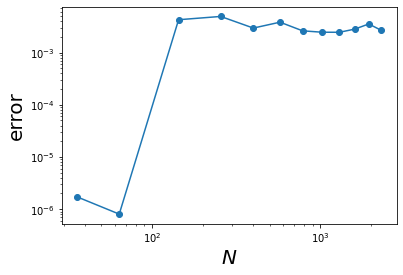

In [3]:
n_grids = np.array(n_grids)
#n_params = (4*n_grids-5)*n_grids
n_params = n_grids**2
#n_params = (n_grids-1)**2
plt.plot(n_params, errors, marker="o")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-8,10e-5)
plt.xlabel(r"$N$",fontsize=20)
plt.ylabel("error",fontsize=20)

In [231]:
start_id = -6
end_id = -1

(np.log(errors[start_id]) - np.log(errors[end_id]))/(np.log(n_params[start_id])-np.log(n_params[end_id]))

-1.9201069227039909

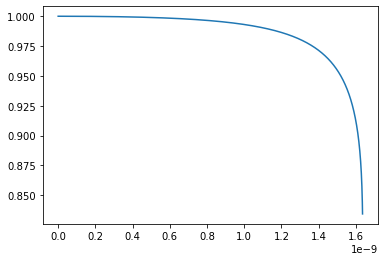

In [235]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

start_id = -6
end_id = -1
loss_w = errors[start_id:end_id]
log_ws = np.log(n_params[start_id:end_id])
log_loss = np.log(errors[start_id:end_id])

reg = LinearRegression().fit(log_ws[:,np.newaxis], log_loss)
eps_max = np.min(loss_w)*0.999

num_sweep = 10001
eps0_sweep = np.linspace(0, eps_max, num=num_sweep)
scores = []

for i in range(num_sweep):
    score = np.abs(scipy.stats.pearsonr(log_ws, np.log(loss_w-eps0_sweep[i]))[0])
    scores.append(score)
    
plt.plot(eps0_sweep, scores)

In [236]:
max_id = np.argmax(scores)
eps0 = eps0_sweep[max_id]
reg.fit(log_ws[:,np.newaxis], np.log(loss_w-eps0))
alpha = reg.coef_[0]
A = np.e**reg.intercept_
print(max_id)
print(eps0)
print(alpha)
print(A)
#[eps0, A, alpha]

0
0.0
-1.9184066707629372
0.0033148606783546743


In [237]:
from scipy.optimize import minimize

def f(x):
    eps0 = x[0]
    A = x[1]
    alpha = x[2]
    return np.mean((loss_w-(A*n_params[start_id:end_id]**alpha+eps0))**2)

x0 = np.array([eps0, A, alpha])
sol = minimize(f, x0, tol=1e-32, options={'gtol':1e-30})
sol

      fun: 5.549117469329293e-23
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([1.49027668e-08, 9.45245568e-18, 2.01377313e-19])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 236
      nit: 0
     njev: 56
   status: 2
  success: False
        x: array([ 0.        ,  0.00331486, -1.91840667])